In [66]:
import re
inspeech = {}
vbind = {'i':0, 'm': 1, 'p':2, 's':3, 'o' : 4, 'n': 5, '1':6,'2':7,'tot': 8}


f = open("/Users/gcrane/github/Thucydides-new-working-materials/thuc-speeches.tsv","r")
for l in f:
    l = re.sub('\s+$','',l)
    m = re.search('([1-8]|[1-8]\.[0-9]+)\.([0-9]+)\-([1-8]|[1-8]\.[0-9]+)\.([0-9]+)$',l)
    if(m):
        book = m[1]
        start = m[2]
        stop = m[4]
        #print(book,start,stop,l)

        args = l.split('\t')
        speaker = args[0]
        location = args[1]
        if( int(stop) < int(start) ):
            print("error",stop,"less than", start,l)
        for x in range(int(start),int(stop)):
            inspeech[str(book)+"."+str(x)] = speaker + '\t' + location
        inspeech[str(book)+"."+stop] = speaker + '\t' + location
        
def getheadrelation(curid,curtbank):
    workl = curtbank[curid]
    m = re.search('head="([^"]+)"',workl)
    if(not m):
        print('nohead',workl)
        return '',''

    headid = m[1]
    workl = curtbank[headid]
    while(re.search('relation="CO"',workl)):
        m = re.search('head="([^"]+)"',workl)
        headid = m[1]
        workl = curtbank[headid]
    #print('hit!',workl)
    m = re.search('head="([^"]+)"\s+relation="([^"]+)"',workl)
    newhead = m[1]
    curtbank[curid] = re.sub('head="([^"]+)"','head="'+newhead+'"',curtbank[curid])
    newrelation = m[2]
    curtbank[curid] = re.sub('relation="([^"]+)"','relation="'+newrelation+'"',curtbank[curid])
    #print('hit2!',newhead,newrelation,workl)
    
    
def getgenre(curcit):
    shortcit = re.sub('\.[0-9]+$','',curcit)

    if(curcit in inspeech):
        curgenre = inspeech[curcit]
    elif( shortcit in inspeech):
        curgenre = inspeech[shortcit]
    else:
        curgenre = 'narrative'
    return(curgenre)

def gettreebank(tbname):
    global vbind
    f = open(tbname)
    curcit = ''
    curtbank = {}
    cittab = {}
    senttab = {}
    sentverbs = {}
    sentcits = {}
    senttexts = {}
    narr_speak_count = {}
    narrative_speech = [0,0]
    narr_speak_count['speech'] = 0
    
    
    for l in f:
        l = re.sub('\s+$','',l)
        
        
        m = re.search('subdoc="([^"]+)"',l)
        if(m):
            curcit = m[1]
            curgenre = getgenre(curcit)
            if(not curgenre in narr_speak_count):
                narr_speak_count[curgenre] = 0
                
            
        m = re.search('form="([^"]+)"',l)
        if(m):
            curform = m[1]
            
        m = re.search('sentence id="([^"]+)"',l)
        if(m):
            sentid = m[1]
            sentverbs[sentid] = [0]
            for i in range(1,len(vbind)):
                sentverbs[sentid].append(0)
            sentcits[sentid] = curcit
            senttexts[sentid] = ''
            
        m = re.search('word id="([^"]+)"',l)
        if(m):
            curid = m[1]
            
            curtbank[curid] = l
            cittab[curid] = curcit
            senttab[curid] = sentid
            narr_speak_count[curgenre] = narr_speak_count[curgenre] + 1
            if(not curgenre == 'narrative'):
                narr_speak_count['speech'] = narr_speak_count['speech'] + 1    
            if(curgenre == 'narrative'):
                narrative_speech[0] = narrative_speech[0] + 1
            else:
                narrative_speech[1] = narrative_speech[1] + 1
            
            sentverbs[sentid][vbind['tot']] = sentverbs[sentid][vbind['tot']] + 1
            if(senttexts[sentid]):
                senttexts[sentid] = senttexts[sentid] + ' '
            senttexts[sentid] = senttexts[sentid] + curform
        
        m = re.search('postag="v(1)',l)
        if(m):
            curv = vbind[m[1]]
            sentverbs[sentid][curv] = sentverbs[sentid][curv] + 1
            
        if(re.search('lemma="ἐγώ"',l)):
            curv = vbind['1']
            sentverbs[sentid][curv] = sentverbs[sentid][curv] + 1
            
        m = re.search('postag="v(2)',l)
        if(m):
            curv = vbind[m[1]]
            sentverbs[sentid][curv] = sentverbs[sentid][curv] + 1
            
        if(re.search('lemma="σύ"',l)):
            curv = vbind['2']
            sentverbs[sentid][curv] = sentverbs[sentid][curv] + 1
            
        m = re.search('postag="v...(.)',l)
        if(m):
            curv = vbind[m[1]]
            sentverbs[sentid][curv] = sentverbs[sentid][curv] + 1
        
        
            
            
    for foo in curtbank:
        workl = curtbank[foo]
        m = re.search('head="([^"]+)"',workl)
        if(m):
            if(not m[1] == '0'):
                curhead = m[1]
                if(re.search('relation="CO"',workl)):
                    #print('\nCO')
                    #print(workl)
                   # print(curtbank[curhead])
                    getheadrelation(foo,curtbank)
                    #print('now',curtbank[foo])
            
            
    return cittab,curtbank,sentcits,sentverbs,senttexts,narr_speak_count,narrative_speech
            
def tbpattern(curtbank,pat1,pat2):
    rval = {}
    for foo in curtbank:
        deprec = curtbank[foo]
        m = re.search(pat1,deprec)
        if(not m):
            continue
            
        m = re.search('head="([^"]+)"',deprec)
        curhead = m[1]
        if(curhead == '0' and not pat2):
            rval[foo] = curhead
            continue
        if(pat2 and not re.search(pat2,curtbank[curhead])):
           # print(pat2,curtbank[curhead])
            continue
        rval[foo] = curhead
        
    return(rval)
            
thucwordcits,thuctb,thuccits,thucsents,thuctexts,thucgenre,thucnarrvsspeech = gettreebank('0003-001.xml')


outf = open('thucsentvbs.tsv','w')

print('cit','gen/spk','loc','sentid','ind-noninds','\t'.join(vbind),'txt',sep='\t',file=outf)
narrs = 0
speeches = 0
narr_ind2non = 0
speech_ind2non = 0

for foo in thuctexts:
    nonind = 0
    noninds = str(thucsents[foo][0]) + '\t'
    listlen = len(vbind)
    for i in range(1,listlen-2):
        noninds = noninds + str(thucsents[foo][i]) + '\t'
        nonind = thucsents[foo][i] + nonind
    noninds = noninds+  str(thucsents[foo][listlen-2]) + '\t'+ str(thucsents[foo][listlen-1]) 
    bookchapsection = thuccits[foo]
    bookchap = re.sub('\.[0-9]+$','',thuccits[foo])
    usecit = bookchap
    indnonind = thucsents[foo][0]-nonind
    
    if(bookchap in inspeech):
        genre = inspeech[bookchap]
        speeches = speeches + 1
        speech_ind2non = speech_ind2non + indnonind
    elif( bookchapsection in inspeech):
        genre = inspeech[bookchapsection]
        speeches = speeches + 1
        usecit = bookchapsection
        speech_ind2non = speech_ind2non + indnonind

        
    else:
        
        genre = 'narrative\ttbd'
        narrs = narrs + 1
        narr_ind2non = narr_ind2non + indnonind
    #if(thucsents[foo][0] and nonind == 0):
    if(thucsents[foo][vbind['2']] and not usecit in inspeech):
        print(thuccits[foo],genre,foo,thucsents[foo][0],noninds,thuctexts[foo],sep='\t')
        
    print(thuccits[foo],genre,foo,indnonind,noninds,thuctexts[foo],sep='\t',file=outf)
        
outf.close()
print('speeches',speeches,speech_ind2non/speeches)
print('narratives',narrs,narr_ind2non/narrs)
            

speeches 1466 -2.42837653478854
narratives 4589 -0.6833732839398562


In [75]:
potoptslist = {}
potoptsfigs = {}

def freqbygenre(wordlist,wordcits):
    retlist = {}
    retlist['speech'] = 0

    for foo in wordlist:
        curcit = wordcits[[foo][0]]
        curgenre = getgenre(curcit)
        if(not curgenre in retlist):
            retlist[curgenre] = 0
        
        retlist[curgenre] = retlist[curgenre] + 1
        if(not curgenre == 'narrative'):
            retlist['speech'] = retlist['speech'] + 1
        
    return(retlist)

def genresort(glist,curgenrelist):
    avglist = {}
    speechhits = 0
    
    for foo in glist:
        cgenre = getgenre(foo)
        avglist[foo] = 1000*(glist[foo]/curgenrelist[foo])
        if(not foo == 'narrative'):
            speechhits = speechhits + glist[foo]
#        else:
#            print('narr',getgenre(foo))
    #print((1000*speechhits/thucnarrvsspeech[1]),speechhits,thucnarrvsspeech[1],'speech',sep='\t')
    for foo in sorted(avglist,key=avglist.get,reverse=True):
        
        print(1000*(glist[foo]/curgenrelist[foo]),glist[foo],curgenrelist[foo],foo,sep='\t')    

potopts = tbpattern(thuctb,'lemma="ἄν"','postag="v...o')

potoptslist = freqbygenre(potopts,thucwordcits)
    
print('instances where Glaux shows ἄν depending on an optative in Thucydides')
genresort(potoptslist,thucgenre)

#for foo in sorted(potoptsfigs,key=potoptsfigs.get,reverse=True):
#    print(1000*(potoptslist[foo]/thucgenre[foo]),potoptslist[foo],thucgenre[foo],foo,sep='\t')

instances where Glaux shows ἄν depending on an optative in Thucydides
13.483146067415731	12	890	Hermocrates	Syracuse
10.683760683760683	5	468	Melians	Melos
10.38961038961039	4	385	Nicias	Syracuse-3
8.968609865470851	4	446	Brasidas	Amphipolis
8.60832137733142	6	697	Brasidas	Acanthus
8.356545961002785	3	359	Brasidas	Northern-Greece
7.407407407407407	10	1350	Athenians	Melos
7.352941176470588	1	136	Teutiaplus	Embatum
6.548175865294668	7	1069	Nicias	Athens
6.479481641468682	3	463	Phormio	Corinthian_Gulf
5.196032120925839	11	2117	Corinthians	Sparta
5.065856129685917	5	987	Archidamus	Sparta
4.578754578754579	5	1092	Alcibiades	Athens
4.344048653344918	5	1151	Spartans	Athens
4.294917680744453	6	1397	Diodotus	Athens
4.152823920265781	5	1204	Pericles	plague
3.9880358923230306	4	1003	Corcyreans	Athens
3.952569169960474	1	253	Demosthenes	Pylos
3.745318352059925	4	1068	Alcibiades	Camarina
3.72093023255814	4	1075	Corinthians	Athens
3.7195415095771867	147	39521	speech
3.599280143971206	6	1667	Plataean

Here are statements about different types of words that show up in Nicias' speeches:

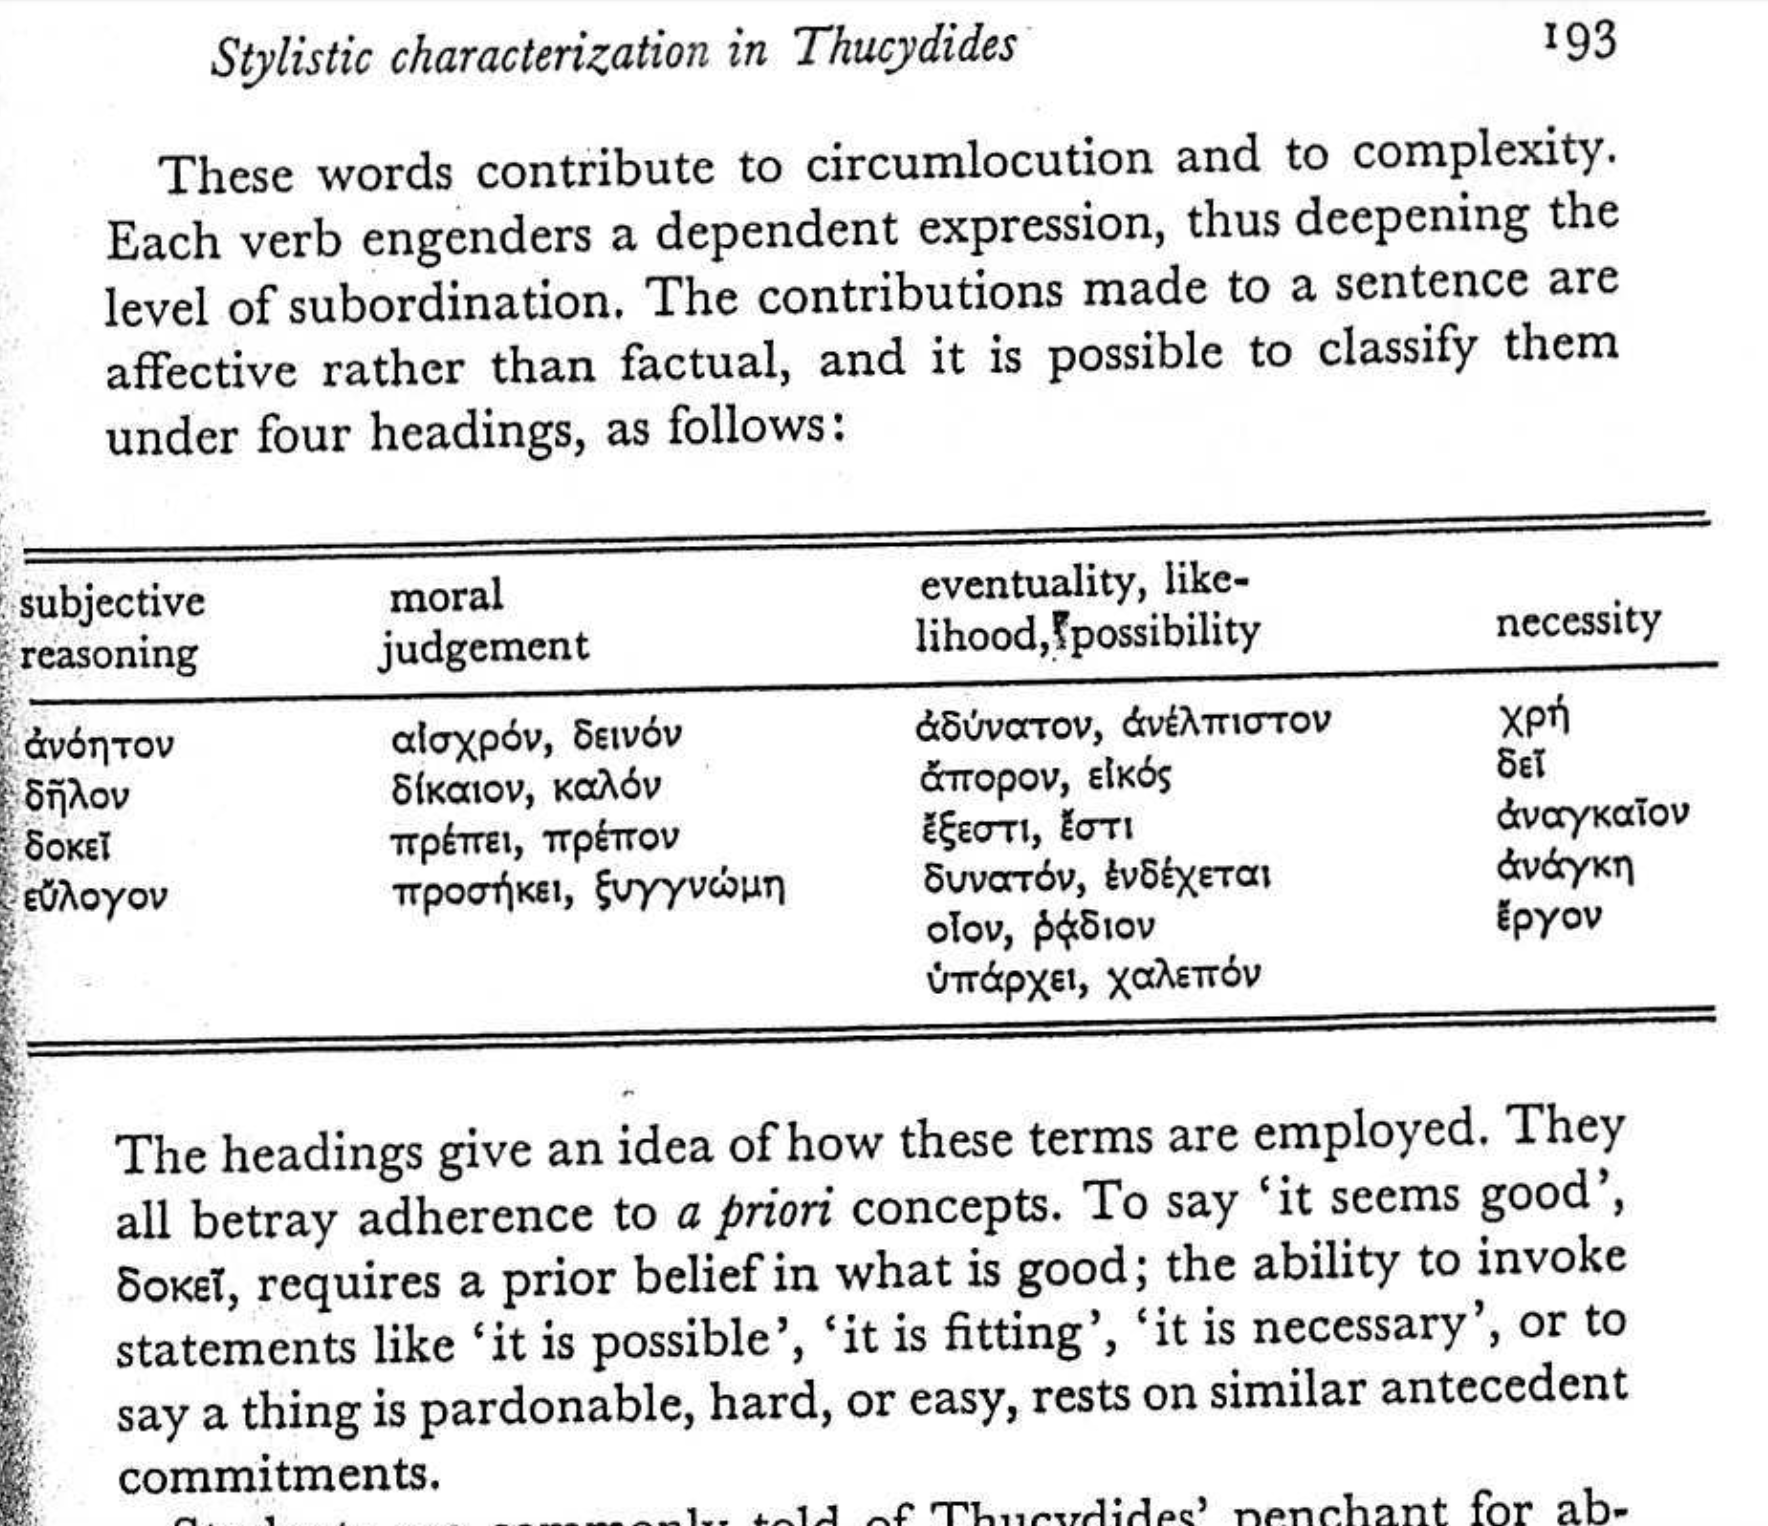

In [72]:
subjective = ['ἀνόητος','δῆλος','δοκέω','εὔλογος']

moralreasoning = ['αἰσχρος','δεινός','δίκαιος','καλός','πρέπω','προσήκω','συγγνώμη','ἀγαθός']

necessity = ['χρή','δεῖ','ἀναγκαἰος','ἀνάγκη']


curset = moralreasoning
print(curset)
rvals = tbpattern(thuctb,'lemma="('+'|'.join(moralreasoning)+')"','')
rvals2 = freqbygenre(rvals,thucwordcits)


#rvals = tbpattern(thuctb,'v...o','')
#rvals2 = freqbygenre(rvals,thucwordcits)
    

genresort(rvals2,thucgenre)


['αἰσχρος', 'δεινός', 'δίκαιος', 'καλός', 'πρέπω', 'προσήκω', 'συγγνώμη', 'ἀγαθός']
7.869234078085069	311	39521	speech
31.25	3	96	Xerxes	Persia
21.604938271604937	7	324	Brasidas+Cnemus	Corinthian_Gulf
19.498607242339833	7	359	Brasidas	Northern-Greece
19.011406844106464	5	263	Sthenelaidas	Sparta
18.01801801801802	2	111	Themistocles	Asia-Minor
17.094017094017097	8	468	Melians	Melos
16.80672268907563	2	119	Hippocrates	Tanagra
15.748031496062993	22	1397	Diodotus	Athens
15.695067264573991	7	446	Brasidas	Amphipolis
15.151515151515152	1	66	Athenians+Spartans-oath	Amphipolis
14.705882352941176	1	68	Athenian+Argive+Peloponnesian-Oath	NA
13.623978201634877	5	367	Archidamus	Isthmus
11.99760047990402	20	1667	Plataeans	Plataea
11.294526498696786	13	1151	Spartans	Athens
11.178388448998604	24	2147	Pericles	funeral-oration
11.160714285714286	15	1344	Cleon	Athens
10.79913606911447	5	463	Phormio	Corinthian_Gulf
10.771992818671455	6	557	Gylippus	Syracuse
10.078387458006718	9	893	Athenagoras	Syracuse
9.73

In [71]:
# who talks about paraskeuê?

curset = ['παρασκευή','παρασκευάζω']
spat = 'lemma="('+'|'.join(curset)+')"'
print(spat)
rvals = tbpattern(thuctb,spat,'')
rvals2 = freqbygenre(rvals,thucwordcits)
genresort(rvals2,thucgenre)

lemma="(παρασκευή|παρασκευάζω)"
1.3157561802585966	52	39521	speech
10.899182561307901	4	367	Archidamus	Isthmus
9.25925925925926	3	324	Brasidas+Cnemus	Corinthian_Gulf
7.092198581560283	1	141	Syracusan-General	Syracuse
6.67779632721202	4	599	Nicias	Athens-2
5.3859964093357275	3	557	Gylippus	Syracuse
5.0	1	200	Nicias	Syracuse
4.552352048558422	3	659	Nicias	Syracuse-2
4.49438202247191	4	890	Hermocrates	Syracuse
4.319654427645789	2	463	Phormio	Corinthian_Gulf
4.052684903748734	4	987	Archidamus	Sparta
3.3594624860022395	3	893	Athenagoras	Syracuse
3.3557046979865772	1	298	Archidamus	Plataea
1.6862879805140056	216	128092	narrative
1.4316392269148175	2	1397	Diodotus	Athens
1.3972985561248255	3	2147	Pericles	funeral-oration
1.2004801920768307	1	833	Nicias-letter	Athens
0.9970089730807576	1	1003	Corcyreans	Athens
0.9532888465204957	1	1049	Hermocrates	Camarina
0.9363295880149812	1	1068	Alcibiades	Camarina
0.9354536950420954	1	1069	Nicias	Athens
0.9157509157509157	1	1092	Alcibiades	Athens
0.9090909

In [58]:
curset = ['μέν']
spat = 'lemma="('+'|'.join(curset)+')"'
print(spat)
rvals = tbpattern(thuctb,spat,'')
rvals2 = freqbygenre(rvals,thucwordcits)
genresort(rvals2,thucgenre)

lemma="(μέν)"
11.057412514865515	437	39521	speech
21.27659574468085	3	141	Syracusan-General	Syracuse
19.230769230769234	1	52	Athenians	Sybota
18.01801801801802	2	111	Themistocles	Asia-Minor
18.00720288115246	15	833	Nicias-letter	Athens
17.77777777777778	24	1350	Athenians	Melos
17.11309523809524	23	1344	Cleon	Athens
16.949152542372882	1	59	Ambraciot-herald+Interlocutor	Olpae
16.71309192200557	6	359	Brasidas	Northern-Greece
16.393442622950822	1	61	Spartan-Messenger	Pylos
16.205910390848427	17	1049	Hermocrates	Camarina
16.15798922800718	9	557	Gylippus	Syracuse
15.115729806329712	32	2117	Corinthians	Sparta
15.107913669064748	21	1390	Thebans	Plataea
15.0	3	200	Nicias	Syracuse
14.957264957264957	7	468	Melians	Melos
14.705882352941176	1	68	Athenian+Argive+Peloponnesian-Oath	NA
13.422818791946309	4	298	Archidamus	Plataea
13.096351730589337	14	1069	Nicias	Athens
12.961116650049851	13	1003	Corcyreans	Athens
12.727272727272728	14	1100	Mytilenians	Olympia
12.531328320802004	5	399	Pagondas	Tanagra


In [59]:

spat = 'v..f'
print(spat)
rvals = tbpattern(thuctb,spat,'')
rvals2 = freqbygenre(rvals,thucwordcits)
genresort(rvals2,thucgenre)

v..f
13.334682826851548	527	39521	speech
40.0	2	50	Athenians	Athens
38.46153846153847	2	52	Athenians	Sybota
29.41176470588235	2	68	Athenian+Argive+Peloponnesian-Oath	NA
25.82496413199426	18	697	Brasidas	Acanthus
24.92522432701894	25	1003	Corcyreans	Athens
21.27659574468085	3	141	Syracusan-General	Syracuse
21.2298682284041	29	1366	Pericles	Athens
20.833333333333332	2	96	Xerxes	Persia
20.0	22	1100	Mytilenians	Olympia
20.0	4	200	Nicias	Syracuse
19.345238095238095	26	1344	Cleon	Athens
19.25925925925926	26	1350	Athenians	Melos
19.250253292806487	19	987	Archidamus	Sparta
18.51851851851852	6	324	Brasidas+Cnemus	Corinthian_Gulf
18.363939899833056	11	599	Nicias	Athens-2
17.953321364452425	10	557	Gylippus	Syracuse
17.159199237368924	18	1049	Hermocrates	Camarina
16.853932584269664	15	890	Hermocrates	Syracuse
16.853932584269664	18	1068	Alcibiades	Camarina
16.7973124300112	15	893	Athenagoras	Syracuse
16.778523489932887	5	298	Archidamus	Plataea
15.6062424969988	13	833	Nicias-letter	Athens
15.5677655

In [21]:
thucnarrvsspeech

[128092, 39521]